In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from tqdm import tqdm


# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


/kaggle/input/ucsd-cse-151b-class-competition/feature_engineering.ipynb
/kaggle/input/ucsd-cse-151b-class-competition/archive/test_public.csv
/kaggle/input/ucsd-cse-151b-class-competition/archive/sampleSubmission.csv
/kaggle/input/ucsd-cse-151b-class-competition/archive/train.csv
/kaggle/input/ucsd-cse-151b-class-competition/archive/metaData_taxistandsID_name_GPSlocation.csv


In [2]:
# read the csv files
test = pd.read_csv('/kaggle/input/ucsd-cse-151b-class-competition/archive/test_public.csv')
train = pd.read_csv('/kaggle/input/ucsd-cse-151b-class-competition/archive/train.csv')
meta = pd.read_csv('/kaggle/input/ucsd-cse-151b-class-competition/archive/metaData_taxistandsID_name_GPSlocation.csv')

sampleSub = pd.read_csv('/kaggle/input/ucsd-cse-151b-class-competition/archive/sampleSubmission.csv')

In [3]:
train.head()

,TRIP_ID,CALL_TYPE,ORIGIN_CALL,ORIGIN_STAND,TAXI_ID,TIMESTAMP,DAY_TYPE,MISSING_DATA,POLYLINE
0,1372636858620000589,C,NaN,NaN,20000589,1372636858,A,False,"[[-8.618643,41.141412],[-8.618499,41.141376],[..."
1,1372637303620000596,B,NaN,7.0,20000596,1372637303,A,False,"[[-8.639847,41.159826],[-8.640351,41.159871],[..."
2,1372636951620000320,C,NaN,NaN,20000320,1372636951,A,False,"[[-8.612964,41.140359],[-8.613378,41.14035],[-..."
3,1372636854620000520,C,NaN,NaN,20000520,1372636854,A,False,"[[-8.574678,41.151951],[-8.574705,41.151942],[..."
4,1372637091620000337,C,NaN,NaN,20000337,1372637091,A,False,"[[-8.645994,41.18049],[-8.645949,41.180517],[-..."


In [4]:
sampleSub.head()

,TRIP_ID,TRAVEL_TIME
0,T1,660
1,T2,660
2,T3,660
3,T4,660
4,T5,660


In [5]:
test.head()

,TRIP_ID,CALL_TYPE,ORIGIN_CALL,ORIGIN_STAND,TAXI_ID,TIMESTAMP,DAY_TYPE,MISSING_DATA
0,T1,B,NaN,15.0,20000542,1408039037,A,False
1,T2,B,NaN,57.0,20000108,1408038611,A,False
2,T3,B,NaN,15.0,20000370,1408038568,A,False
3,T4,B,NaN,53.0,20000492,1408039090,A,False
4,T5,B,NaN,18.0,20000621,1408039177,A,False


In [6]:
meta.head()

,ID,Descricao,Latitude,Longitude
0,1,Agra,41.1771457135,-8.609670
1,2,Alameda,41.15618964,-8.591064
2,3,Aldoar,41.1705249231,-8.665876
3,4,Alfândega,41.1437639911,-8.621803
4,5,Amial,41.1835097223,-8.612726


In [7]:
print(train.shape)
print(test.shape)
print(sampleSub.shape)
print(meta.shape)

(1710670, 9)
(320, 8)
(320, 2)
(63, 4)


In [8]:
#observe what the polyline data looks like
train['POLYLINE'][0]

'[[-8.618643,41.141412],[-8.618499,41.141376],[-8.620326,41.14251],[-8.622153,41.143815],[-8.623953,41.144373],[-8.62668,41.144778],[-8.627373,41.144697],[-8.630226,41.14521],[-8.632746,41.14692],[-8.631738,41.148225],[-8.629938,41.150385],[-8.62911,41.151213],[-8.629128,41.15124],[-8.628786,41.152203],[-8.628687,41.152374],[-8.628759,41.152518],[-8.630838,41.15268],[-8.632323,41.153022],[-8.631144,41.154489],[-8.630829,41.154507],[-8.630829,41.154516],[-8.630829,41.154498],[-8.630838,41.154489]]'

In [9]:
#identify amount/proportion of "is missing" data
train['MISSING_DATA'].sum()

10

In [10]:
#james's function to convert polyline to seconds quickly
def polyline_to_trip_duration(polyline):
  return max(polyline.count("[") - 2, 0) * 15

In [11]:
#initial distribution of travel times
out = train["POLYLINE"].apply(polyline_to_trip_duration)
out.describe()
#sns.histplot(out)

count    1.710670e+06
mean     7.164265e+02
std      6.847512e+02
min      0.000000e+00
25%      4.050000e+02
50%      6.000000e+02
75%      8.700000e+02
max      5.820000e+04
Name: POLYLINE, dtype: float64

In [12]:
from datetime import datetime
def parse_time(x):
  # We are using python's builtin datetime library
  # https://docs.python.org/3/library/datetime.html#datetime.date.fromtimestamp

  # Each x is essentially a 1 row, 1 column pandas Series
  dt = datetime.fromtimestamp(x["TIMESTAMP"])
  return dt.year, dt.month, dt.day, dt.hour, dt.weekday()

In [13]:
#identify the longest trip in the graph
arr = np.array(out)

arr.max()

58200

2770.6793463905606
Proportion of data with 3 standard deviations: 0.9895368481355259
1692771


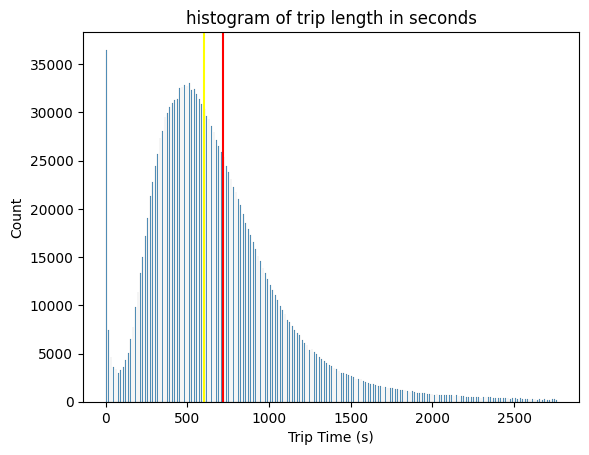

In [14]:
#get distribution of travel times / proportion of data within 3 standard deviations
mean = arr.mean()
std = arr.std()
outlier_threshold = 3
threshold = mean + outlier_threshold * std
print(threshold)
selected = arr[arr < threshold]
sns.histplot(selected,
             binwidth = 5)
plt.axvline(x=arr.mean(), color='red')
plt.axvline(x=np.median(arr), color='yellow')
#plt.xlim(0, 1000)
plt.title('histogram of trip length in seconds')
plt.xlabel("Trip Time (s)")
print('Proportion of data with 3 standard deviations: ' + str((np.shape(selected)[0]/np.shape(arr)[0])))
print(np.shape(selected)[0])

Proportion of data with 3 standard deviations: 0.9895368481355259
red is the mean, yellow is the mediam


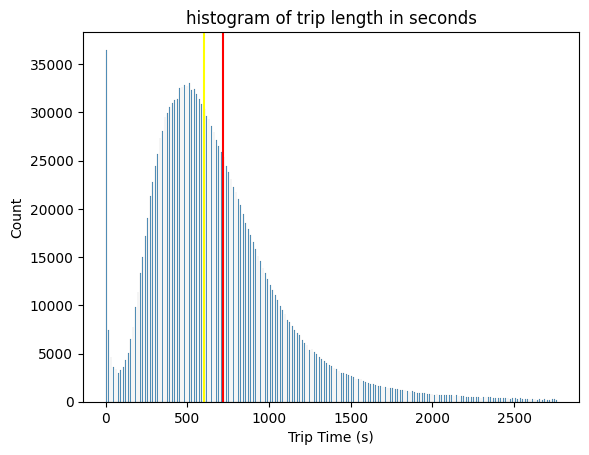

In [15]:
sns.histplot(selected,
             binwidth = 5)
plt.axvline(x=arr.mean(), color='red')
plt.axvline(x=np.median(arr), color='yellow')
#plt.xlim(0, 1000)
plt.title('histogram of trip length in seconds')
plt.xlabel("Trip Time (s)")
print('Proportion of data with 3 standard deviations: ' + str((np.shape(selected)[0]/np.shape(arr)[0])))
print('red is the mean, yellow is the mediam')

In [16]:
#too many entries with 0 second trip times, count them
frequency = np.count_nonzero(arr == 0)
frequency

36510

In [17]:
#Get proportion of NaN values for ORIGIN_CALL
train['ORIGIN_CALL'].isna().sum() / train.shape[0]

0.7867677576622025

In [18]:
#Get proportion of duplicate trips (sharing ids assumed to be duplicate)
trips = len(train['TRIP_ID'].unique())
print((train.shape[0] - trips) / train.shape[0])

4.73498687648699e-05


In [19]:
#identify duplicate IDs
dup = train[train.duplicated(['TRIP_ID'])]
print(dup['TRIP_ID'].unique())

[1372702836620000080 1373025987620000601 1373210896620000598
 1373551710620000014 1374014097620000337 1374151597620000080
 1374157861620000328 1374262188620000554 1378607552620000403
 1378830230620000435 1378866507620000648 1381308181620000352
 1381645412620000328 1381765723620000392 1381859675620000465
 1382450880620000432 1383341250620000588 1383557098620000562
 1385631430620000080 1385772222620000263 1385928574620000080
 1385928575620000080 1386167379620000080 1386942349620000080
 1386947218620000080 1387206043620000080 1387839159620000080
 1387937085620000080 1387909459620000429 1388279758620000080
 1388526838620000080 1389002485620000685 1389561280620000080
 1389782974620000562 1391186543620000513 1391416612620000196
 1391586783620000484 1391717369620000663 1391729840620000663
 1391931520620000286 1392271509620000286 1392317061620000066
 1392499655620000663 1392640481620000663 1392816672620000663
 1393315427620000513 1393462842620000620 1393472034620000620
 1393686091620000161 139

In [20]:
#Get the number of unique taxis across test and train datasets
print(train['TAXI_ID'].unique().shape)
print(len(set(test['TAXI_ID']).intersection(set(train['TAXI_ID']))))
print(len(set(test['TAXI_ID'])))


(448,)
244
244


In [21]:
#Get the day types that exist in the train dataset
print(train['DAY_TYPE'].unique())
print(test['DAY_TYPE'].unique())

['A']
['A']


In [22]:
#track all latitiude and longitude points collected by the taxis
import plotly.express as px
trips = train['POLYLINE'][:]
allTripsLat = {}
allTripsLong = {}
tripsLat = []
tripsLong = []
xcoord = 0
xcoordx = 0
testcoords = 0
j = 0
i = 0
for x in tqdm(trips):
    #print(j)
    if x != '[]':
        testcoords = x[1:-1].replace('],[', ']/[').split('/')
        for xcoord in testcoords:
            #print(i)
            xcoordx = xcoord[1:-1].split(',')
            long = float(xcoordx[0])
            lat = float(xcoordx[1])
            allTripsLat[i] = lat
            allTripsLong[i] = long
            tripsLat.append(lat)
            tripsLong.append(long)
            
            i = i + 1
    j = j+1
#print(allTripsLat)
#print(allTripsLong)
 

100%|██████████| 1710670/1710670 [03:12<00:00, 8878.21it/s] 


In [23]:
#df2=pd.DataFrame({'latitude': allTripsLat, 'longitude': allTripsLong})

#fig = px.density_mapbox(df2, lat='latitude', lon='longitude', mapbox_style="stamen-terrain", radius=5)
#print('success')
#fig

83409386


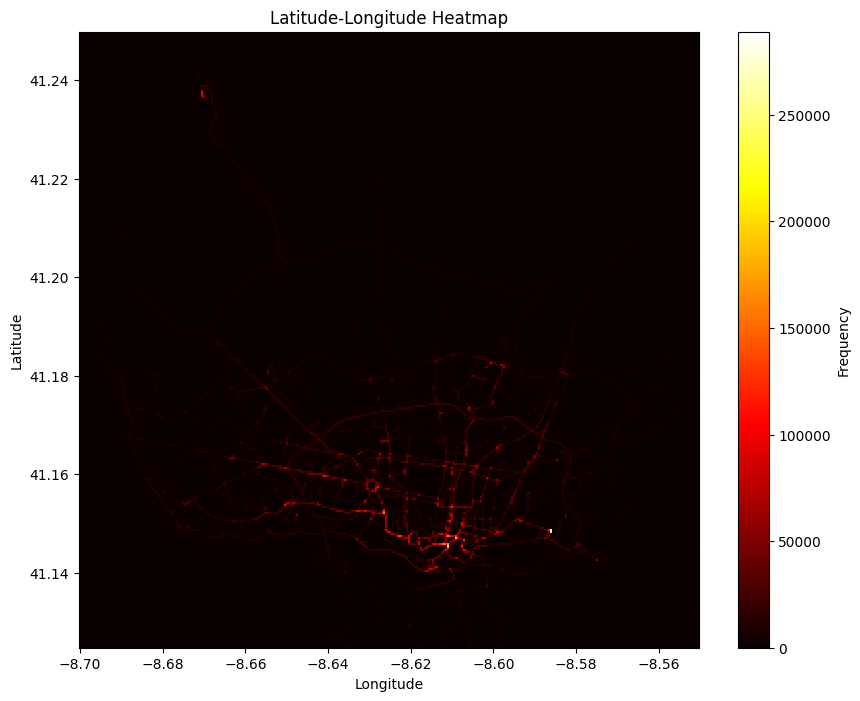

In [24]:
#generate heatmap
x_min, x_max = np.min(tripsLat), np.max(tripsLat)
y_min, y_max = np.min(tripsLong), np.max(tripsLong)
heatmap, xedges, yedges = np.histogram2d(tripsLong, tripsLat, bins=300, range=[[-8.7, -8.55], [41.125, 41.250]]) #[[41.125, 41.250], [-8.7, -8.55]]
print(len(tripsLong))
# Create a meshgrid for the heatmap
x, y = np.meshgrid(xedges[:-1], yedges[:-1])
# Plot the heatmap
plt.figure(figsize=(10, 8))
plt.pcolormesh(x, y, heatmap.T, cmap='hot')
plt.colorbar(label='Frequency')
plt.title('Latitude-Longitude Heatmap')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()

TRAINING DATA PREPROCESSING

In [25]:
#reread original csv and sort by time
train = pd.read_csv('/kaggle/input/ucsd-cse-151b-class-competition/archive/train.csv')
train.sort_values('TIMESTAMP',inplace = True)
train.head()

,TRIP_ID,CALL_TYPE,ORIGIN_CALL,ORIGIN_STAND,TAXI_ID,TIMESTAMP,DAY_TYPE,MISSING_DATA,POLYLINE
577,1372636853620000380,C,NaN,NaN,20000380,1372636853,A,False,"[[-8.610291,41.140746],[-8.6103,41.140755],[-8..."
3,1372636854620000520,C,NaN,NaN,20000520,1372636854,A,False,"[[-8.574678,41.151951],[-8.574705,41.151942],[..."
0,1372636858620000589,C,NaN,NaN,20000589,1372636858,A,False,"[[-8.618643,41.141412],[-8.618499,41.141376],[..."
10,1372636875620000233,C,NaN,NaN,20000233,1372636875,A,False,"[[-8.619894,41.148009],[-8.620164,41.14773],[-..."
64,1372636896620000360,C,NaN,NaN,20000360,1372636896,A,False,"[[-8.617599,41.146137],[-8.617581,41.14593],[-..."


In [26]:
train.describe()

,TRIP_ID,ORIGIN_CALL,ORIGIN_STAND,TAXI_ID,TIMESTAMP
count,1.710670e+06,364770.000000,806579.000000,1.710670e+06,1.710670e+06
mean,1.388622e+18,24490.363018,30.272381,2.000035e+07,1.388622e+09
std,9.180944e+15,19624.290043,17.747840,2.112405e+02,9.180944e+06
min,1.372637e+18,2001.000000,1.000000,2.000000e+07,1.372637e+09
25%,1.380731e+18,6593.000000,15.000000,2.000017e+07,1.380731e+09
50%,1.388493e+18,18755.000000,27.000000,2.000034e+07,1.388493e+09
75%,1.396750e+18,40808.000000,49.000000,2.000052e+07,1.396750e+09
max,1.404173e+18,63884.000000,63.000000,2.000098e+07,1.404173e+09


In [27]:
#drop rows with MISSING_DATA 
train = train[train['MISSING_DATA'] == False]
train = train.drop('MISSING_DATA', axis=1)
print(train.shape)

train.head()

(1710660, 8)


,TRIP_ID,CALL_TYPE,ORIGIN_CALL,ORIGIN_STAND,TAXI_ID,TIMESTAMP,DAY_TYPE,POLYLINE
577,1372636853620000380,C,NaN,NaN,20000380,1372636853,A,"[[-8.610291,41.140746],[-8.6103,41.140755],[-8..."
3,1372636854620000520,C,NaN,NaN,20000520,1372636854,A,"[[-8.574678,41.151951],[-8.574705,41.151942],[..."
0,1372636858620000589,C,NaN,NaN,20000589,1372636858,A,"[[-8.618643,41.141412],[-8.618499,41.141376],[..."
10,1372636875620000233,C,NaN,NaN,20000233,1372636875,A,"[[-8.619894,41.148009],[-8.620164,41.14773],[-..."
64,1372636896620000360,C,NaN,NaN,20000360,1372636896,A,"[[-8.617599,41.146137],[-8.617581,41.14593],[-..."


In [28]:
#drop rows with empty polyline
print(train[train['POLYLINE'] =='[]'].shape)
train = train.drop(train[train['POLYLINE'] =='[]']['POLYLINE'].index)
#train = train.drop(train[train['POLYLINE'] == '[]']['POLYLINE'].index, inplace = True)
print(train.shape)

(5901, 8)
(1704759, 8)


In [29]:
tqdm.pandas()

In [30]:
#use james zhao's function to convert polyline into trip time in secs
train["tripTimeSec"] = train["POLYLINE"].progress_apply(polyline_to_trip_duration)
print(train.shape)
train['tripTimeSec'].describe()


100%|██████████| 1704759/1704759 [00:07<00:00, 234281.97it/s]

(1704759, 9)


count    1.704759e+06
mean     7.189021e+02
std      6.846122e+02
min      0.000000e+00
25%      4.050000e+02
50%      6.000000e+02
75%      8.700000e+02
max      5.820000e+04
Name: tripTimeSec, dtype: float64

In [31]:
#drop entries with 0 length trip time - may be somethig to address later
print(train[train['tripTimeSec'] == 0].shape)
train = train.drop(train[train['tripTimeSec'] ==0]['tripTimeSec'].index)
print(train.shape)

(30607, 9)
(1674152, 9)


In [32]:
#tconvert the timestamp into proper data/time
train[["YR", "MON", "DAY", "HR", "WK_DAY"]] = train[['TIMESTAMP']].progress_apply(parse_time, axis=1, result_type="expand")

print(train.shape)

train.head()

100%|██████████| 1674152/1674152 [01:49<00:00, 15280.53it/s]

(1674152, 14)


,TRIP_ID,CALL_TYPE,ORIGIN_CALL,ORIGIN_STAND,TAXI_ID,TIMESTAMP,DAY_TYPE,POLYLINE,tripTimeSec,YR,MON,DAY,HR,WK_DAY
577,1372636853620000380,C,NaN,NaN,20000380,1372636853,A,"[[-8.610291,41.140746],[-8.6103,41.140755],[-8...",360,2013,7,1,0,0
3,1372636854620000520,C,NaN,NaN,20000520,1372636854,A,"[[-8.574678,41.151951],[-8.574705,41.151942],[...",630,2013,7,1,0,0
0,1372636858620000589,C,NaN,NaN,20000589,1372636858,A,"[[-8.618643,41.141412],[-8.618499,41.141376],[...",330,2013,7,1,0,0
10,1372636875620000233,C,NaN,NaN,20000233,1372636875,A,"[[-8.619894,41.148009],[-8.620164,41.14773],[-...",315,2013,7,1,0,0
64,1372636896620000360,C,NaN,NaN,20000360,1372636896,A,"[[-8.617599,41.146137],[-8.617581,41.14593],[-...",630,2013,7,1,0,0


In [33]:
#Drop day_type col
train = train.drop('DAY_TYPE', axis=1)
print(train.shape)

(1674152, 13)


In [34]:
#drop duplicated trip id
train = train.drop_duplicates(subset=['TRIP_ID'])
print(train.shape)

(1674141, 13)


In [35]:
#drop trips with lengths longer than three standard deviations
mean = train['tripTimeSec'].mean()
std = train['tripTimeSec'].std()
outlier_threshold = 3
print(mean)
print(std)
threshold = mean + outlier_threshold * std
print(train[train['tripTimeSec'] < threshold].shape)

732.0483400143715
683.842580336944
(1656475, 13)


In [36]:
train = train[train['tripTimeSec'] < threshold]

In [37]:
#convert NaNs in origincall/origin stand to zeros
train[["ORIGIN_CALL", "ORIGIN_STAND"]] = train[["ORIGIN_CALL", "ORIGIN_STAND"]].fillna(0)
train.head()

,TRIP_ID,CALL_TYPE,ORIGIN_CALL,ORIGIN_STAND,TAXI_ID,TIMESTAMP,POLYLINE,tripTimeSec,YR,MON,DAY,HR,WK_DAY
577,1372636853620000380,C,0.0,0.0,20000380,1372636853,"[[-8.610291,41.140746],[-8.6103,41.140755],[-8...",360,2013,7,1,0,0
3,1372636854620000520,C,0.0,0.0,20000520,1372636854,"[[-8.574678,41.151951],[-8.574705,41.151942],[...",630,2013,7,1,0,0
0,1372636858620000589,C,0.0,0.0,20000589,1372636858,"[[-8.618643,41.141412],[-8.618499,41.141376],[...",330,2013,7,1,0,0
10,1372636875620000233,C,0.0,0.0,20000233,1372636875,"[[-8.619894,41.148009],[-8.620164,41.14773],[-...",315,2013,7,1,0,0
64,1372636896620000360,C,0.0,0.0,20000360,1372636896,"[[-8.617599,41.146137],[-8.617581,41.14593],[-...",630,2013,7,1,0,0


In [38]:
#add columns with the starting latitude, longitude , and stand name for each trip. if nan then we will use 0.0
def create_dictionary(df):
    dictionary = {}
    for index, row in df.iterrows():
        id = row['ID']
        loc = row['Descricao']
        latitude = row['Latitude']
        longitude = row['Longitude']
        latitude, longitude = split_string(latitude, longitude)
        dictionary[id] = (loc, latitude, longitude)
    dictionary[0] = ('None', 0.0, 0.0)
    return dictionary

def split_string(lat, lng):
    if '-' in lat and lat.index('-') != 0:
        index = lat.find('-')
        left = lat[0:index]
        right = lat[index:]
        return float(left), float(right)
    else:
        return float(lat), float(lng)

standDict = create_dictionary(meta)
standDict

{1: ('Agra', 41.1771457135, -8.6096702714),
 2: ('Alameda', 41.15618964, -8.59106440506),
 3: ('Aldoar', 41.1705249231, -8.66587593213),
 4: ('Alfândega', 41.1437639911, -8.62180322015),
 5: ('Amial', 41.1835097223, -8.61272586967),
 6: ('Areosa', 41.1808043369, -8.58278289063),
 7: ('Av. Boavista', 41.1599801853, -8.64198392478),
 8: ('Azevedo', 41.1515920975, -8.56819539682),
 9: ('Batalha', 41.1442525263, -8.60571961615),
 10: ('Bolhão', 41.1507106526, -8.60690977259),
 11: ('Bom Pastor', 41.1670339026, -8.61326686188),
 12: ('Bom Sucesso', 41.1551197292, -8.63046626628),
 13: ('Brasília', 41.1570891314, -8.6284679801),
 14: ('Câmara', 41.1497021913, -8.6110708703),
 15: ('Campanhã', 41.1486275073, -8.58587660305),
 16: ('Campismo', 41.1754722349, -8.62779145139),
 17: ('Carcereira', 41.1644515812, -8.63228595529),
 18: ('Carregal', 41.1483209068, -8.61960347647),
 19: ('Carvalheiras', 41.1535929278, -8.60542646661),
 20: ('Carvalhido', 41.1669278236, -8.62677872999),
 21: ('Casa da

In [39]:
#continuation of previous code block
train['ORIGIN'] = train['ORIGIN_STAND'].map(lambda x: (standDict.get(x)[0]))
train['STAND_LAT'] = train['ORIGIN_STAND'].map(lambda x: (standDict.get(x)[1]))
train['STAND_LONG'] = train['ORIGIN_STAND'].map(lambda x: (standDict.get(x)[2]))

print(train['ORIGIN_STAND'][:-1].dtype)
print(train['STAND_LAT'][:-1].dtype)
print(train['STAND_LONG'][:-1].dtype)
#train.loc[train['ORIGIN_STAND'] != 0].head(10)

float64
float64
float64


In [40]:
train.head()
for index, value in train['ORIGIN_STAND'].iteritems():
    if float(value) == 33.0 or float(value) == 39.0:
        train.loc[index, 'IS_HOSPITAL'] = 1
    else:
        train.loc[index, 'IS_HOSPITAL'] = 0
    indexes = [2.0, 3.0, 26.0, 28.0, 44.0]
    if float(value) in indexes:
        train.loc[index, 'IS_STADIUM'] = 1
    else:
        train.loc[index, 'IS_STADIUM'] = 0
    indexes = [1.0, 25.0, 33.0, 42.0, 49.0]
    if float(value) in indexes:
        train.loc[index, 'IS_UNIV'] = 1
    else:
        train.loc[index, 'IS_UNIV'] = 0
    # Check if the value is within the range
    #if lower_bound <= value <= upper_bound:
    #    df.loc[index, 'NewColumn'] = 1

/tmp/ipykernel_34/11897529.py:2: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for index, value in train['ORIGIN_STAND'].iteritems():


In [41]:
print(train[train['IS_HOSPITAL'] == 0.0].shape)
print(train[train['IS_HOSPITAL'] != 0.0].shape)
print(train[train['IS_STADIUM'] == 0.0].shape)
print(train[train['IS_STADIUM'] != 0.0].shape)
print(train[train['IS_UNIV'] == 0.0].shape)
print(train[train['IS_UNIV'] != 0.0].shape)

(1621412, 19)
(35063, 19)
(1627879, 19)
(28596, 19)
(1580448, 19)
(76027, 19)


766
11


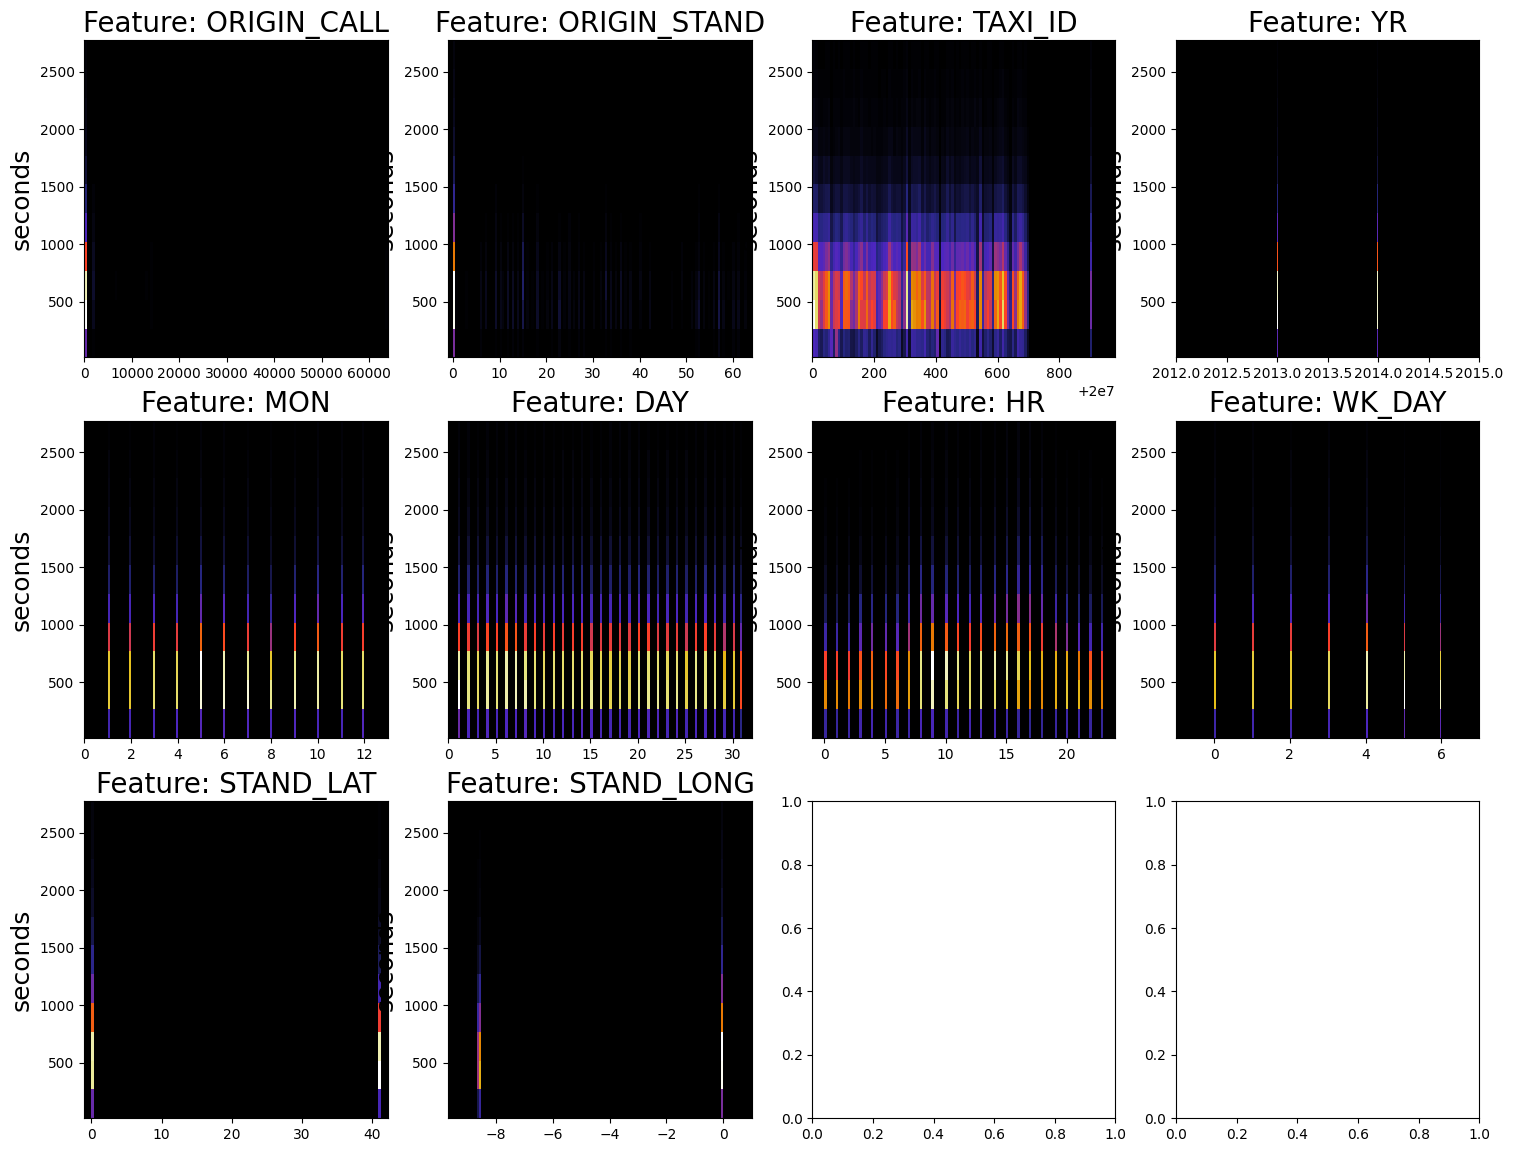

In [42]:
#create histograms of trip times for the following fields: ORIGIN_CALL", "ORIGIN_STAND", "TAXI_ID", "YR", "MON", "DAY", "HR", "WK", "STAND_LAT", "STAND_LONG
#tentative: origin_stand, taxi_id, hr, week, calltype, origin (red one only), and stand-long contain learnable information
end = -1
mean = train['tripTimeSec'].mean()
std = train['tripTimeSec'].std()
threshold = 3  # Set your threshold here

buckets = int((mean + threshold * std // 15))
print(buckets)

threshold = 10
buckets = (int(threshold) // 1) + 1  # Adjust the number of bins based on the threshold
print(buckets)

fig, axs = plt.subplots(nrows=3, ncols=4, figsize=(18,14))

for idx, v in enumerate(["ORIGIN_CALL", "ORIGIN_STAND", "TAXI_ID", "YR", "MON", "DAY", "HR", "WK_DAY", "STAND_LAT", "STAND_LONG"]):
    ax = axs[idx // 4, idx % 4]
    df_subset = train.dropna(subset=[v])
    ax.hist2d(df_subset[v][:end], df_subset["tripTimeSec"][:end], cmap="CMRmap", bins=(120, buckets))
    ax.set_xlim(ax.get_xlim()[0] - 1, ax.get_xlim()[1] + 1)
    ax.set_facecolor("black")
    ax.set_ylabel("seconds", fontsize=18)
    ax.set_title(f"Feature: {v}", fontsize=20)


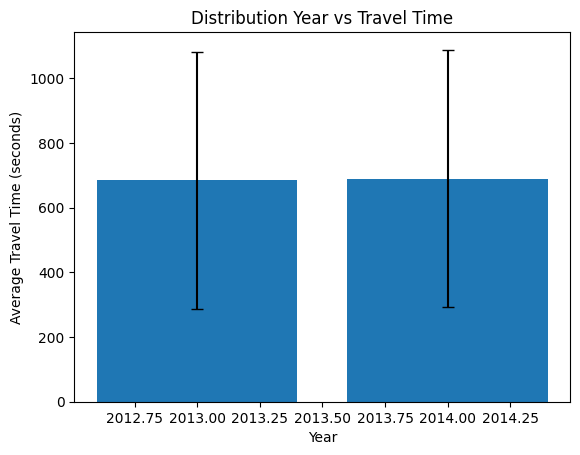

In [43]:
# Group the data by Year
grouped_data = train.groupby('YR')['tripTimeSec'].agg(['mean', 'std'])

# Plotting the bar chart
x = grouped_data.index
y = grouped_data['mean']
error = grouped_data['std']

plt.bar(x, y, yerr=error, capsize=4)
plt.xlabel('Year')
plt.ylabel('Average Travel Time (seconds)')
plt.title('Distribution Year vs Travel Time')
plt.show()

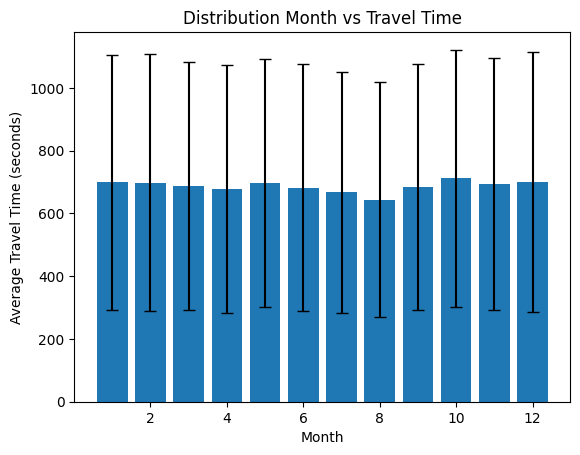

In [44]:
# Group the data by Month
grouped_data = train.groupby('MON')['tripTimeSec'].agg(['mean', 'std'])

# Plotting the bar chart
x = grouped_data.index
y = grouped_data['mean']
error = grouped_data['std']

plt.bar(x, y, yerr=error, capsize=4)
plt.xlabel('Month')
plt.ylabel('Average Travel Time (seconds)')
plt.title('Distribution Month vs Travel Time')
plt.show()

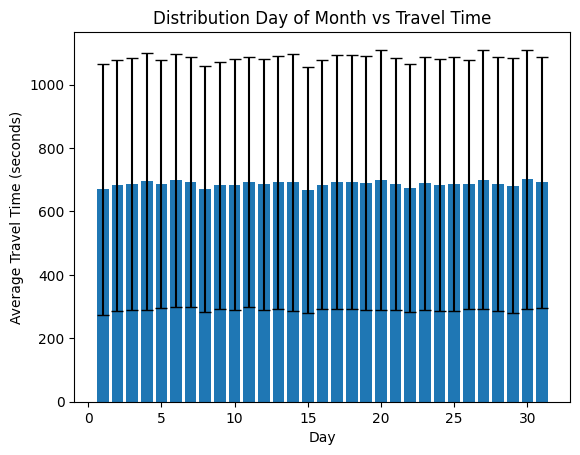

In [45]:
# Group the data by Day (mislabeled as Year)
grouped_data = train.groupby('DAY')['tripTimeSec'].agg(['mean', 'std'])

# Plotting the bar chart
x = grouped_data.index
y = grouped_data['mean']
error = grouped_data['std']

plt.bar(x, y, yerr=error, capsize=4)
plt.xlabel('Day')
plt.ylabel('Average Travel Time (seconds)')
plt.title('Distribution Day of Month vs Travel Time')
plt.show()

(1656475, 19)
(794144, 19)


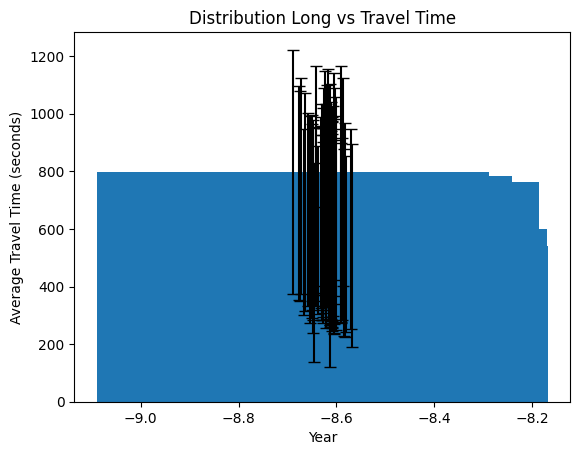

In [46]:
# Group the data by Longitude of origin stand (except those that aren't available)
print(train.shape)
train2 = train[train['STAND_LONG'] != 0.0]
print(train2.shape)
grouped_data = train2.groupby('STAND_LONG')['tripTimeSec'].agg(['mean', 'std'])

# Plotting the bar chart
x = grouped_data.index
y = grouped_data['mean']
error = grouped_data['std']

plt.bar(x, y, yerr=error, capsize=4)
plt.xlabel('Year')
plt.ylabel('Average Travel Time (seconds)')
plt.title('Distribution Long vs Travel Time')
plt.show()

1          270
372        405
15         945
16         960
136        630
          ... 
1710493    255
1710341    195
1710544    135
1710412     45
1710532     15
Name: tripTimeSec, Length: 805250, dtype: int64


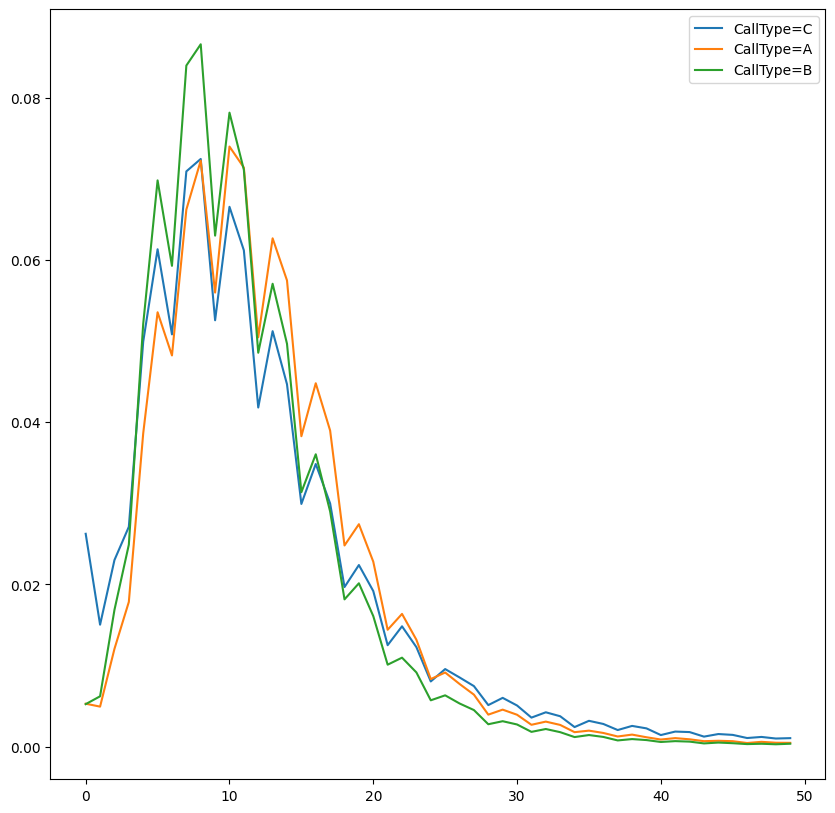

In [47]:
#chart out frequencies for different call types
plt.figure(figsize=(10,10))
for v in train['CALL_TYPE'].unique():
  # Filter data where the HR matches v
  myData = train[train["CALL_TYPE"] == v]["tripTimeSec"]
  histogram, bin_boundary = np.histogram(myData, bins=50)
  histogram = histogram / len(myData)
  # The center is the left_bound and right_bound of a bucket
    #bin_centers = [(bin_boundary[i] + bin_boundary[i + 1]) / 2 for i in range(buckets)]
  plt.plot(histogram, label=f"CallType={v}")
plt.legend();
print(myData)

In [ ]:
#chart out frequencies for different taxi stops
plt.figure(figsize=(10,10))
for v in train['ORIGIN'].unique():
  # Filter data where the HR matches v
  myData = train[train["ORIGIN"] == v]["tripTimeSec"]
  histogram, bin_boundary = np.histogram(myData, bins=50)
  histogram = histogram / len(myData)
  # The center is the left_bound and right_bound of a bucket
    #bin_centers = [(bin_boundary[i] + bin_boundary[i + 1]) / 2 for i in range(buckets)]
  plt.plot(histogram, label=f"={v}")
plt.legend();

In [ ]:
train[train['STAND_LONG'] != 0.0].head()

In [ ]:
train.head()

In [51]:
#save all fields into csv (except trip id, timestamp, polyline)
train_cleaned = train[['CALL_TYPE', 'ORIGIN_CALL', 'ORIGIN_STAND', 'TAXI_ID', 'MON', 'DAY', 'HR', 'YR', 'WK_DAY', 'ORIGIN', 'STAND_LAT', 'STAND_LONG', 'IS_HOSPITAL', 'IS_STADIUM', 'IS_UNIV', 'tripTimeSec']]
train_cleaned.head()
train_cleaned.to_csv('train_cleaned.csv', index=False)